# Optimised Infill Designs using Force Profiles

by James Gopsill

![Alt Text](header_fig.png)

![center](stress_beam.jpg)

<hr>

This notebook provides an example of generating a infill design for a Fused Deposition Modelled part that aligns material with the force profiles within the part.

In [20]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

import numpy as np
import pickle
from scipy import interpolate
import matplotlib.pyplot as plt
import networkx as nx
import pyx
import sympy.geometry as geometry

## Creating the perimeter of the beam

In [21]:
perimeter_lines = []

perimeter = pyx.path.line(-50.0,-20.0, 50.0,-20.0)
perimeter.append(pyx.path.lineto(50.0, 20.0))
perimeter.append(pyx.path.lineto(-50.0, 20.0))
perimeter.append(pyx.path.lineto(-50.0, -20.0))

perimeter_lines.append(perimeter)

offset = [0.9, 1.8] # Note inner one will be used to stop the line overflowing
print('Perimeter Offset:', offset)
for value in offset:
    perimeter_lines.append(pyx.deformer.parallel(value).deform(perimeter))

Perimeter Offset: [0.9, 1.8]


## Plotting Perimeter Lines

In [22]:
perimeter_plot = pyx.canvas.canvas()
for i in range(0, len(perimeter_lines)):
    line = perimeter_lines[i]
    perimeter_plot.stroke(line, [pyx.color.rgb.black, pyx.style.linewidth(0.3)])
    
perimeter_plot.writeSVGfile('perimeter_plot.svg')

![center](perimeter_plot.svg)

## Loading and Interpolating the FEA Data

In [23]:
fea_data = pickle.load(open('three_point_beam.pkl', 'rb'))

print(fea_data)

print('x min:', np.min(fea_data[:,0]), 'x max:', np.max(fea_data[:,0]))
print('y min:', np.min(fea_data[:,1]), 'y max:', np.max(fea_data[:,1]))
print('z min:', np.min(fea_data[:,2]), 'z max:', np.max(fea_data[:,2]))


print('Generating Grid Data')
dx = np.arange(-50, 50, 0.5)
dy = np.arange(-20, 20, 0.5)
X, Y = np.meshgrid(dx, dy)
m = interpolate.griddata(fea_data[:,0:2], fea_data[:,3], (X, Y), method='linear')

print('Grid Data - Max:', np.max(m), ', Min:', np.min(m))

[[-50.         20.          4.          0.0630604]
 [-50.         19.3333      4.          0.082949 ]
 [-49.3333     19.3333      4.          0.143756 ]
 ..., 
 [-30.6667      8.66667     4.         37.8364   ]
 [-30.          8.          4.         38.3281   ]
 [-30.          8.66667     4.         38.0116   ]]
x min: -50.0 x max: 50.0
y min: -20.0 y max: 20.0
z min: 4.0 z max: 4.0
Generating Grid Data
Grid Data - Max: 1866.71518285 , Min: 0.0779761042148


## Plotting the Interpolated FEA Data

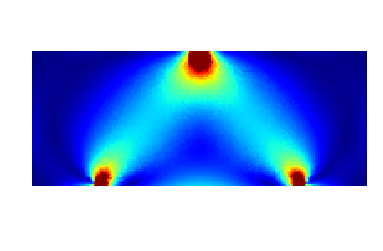

In [24]:
plt.pcolor(m, vmax=np.max(m) / 4)
plt.axis('equal')
plt.axis('off')
plt.show()

In [25]:
g = nx.Graph()

# add nodes
for i, x in enumerate(dx):
    for j, y in enumerate(dy):
        node_name = str(x)+'_'+str(y)
        #print(node_name)
        g.add_node(node_name, x=x, y=y, stress=m[j, i])
        
print(len(dx), len(dy))
print(m.shape)

weightings = []
for x in range(1, len(dx)-1):
    for y in range(1, len(dy)-1):
        from_node = str(dx[x])+'_'+str(dy[y])
        
        # left
        to_node = str(dx[x-1])+'_'+str(dy[y])
        if not g.has_edge(from_node, to_node):
            #weighting = np.abs( m[y,x] - m[y,x-1] )
            weighting = 2000.0 - (m[y, x] +  m[y, x-1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)
        
        # bottom-left
        to_node = str(dx[x-1])+'_'+str(dy[y-1])
        if not g.has_edge(from_node, to_node):
            #weighting = np.abs( m[y,x] - m[y-1,x+1] )
            weighting = 2000.0 - (m[y, x] +  m[y-1, x+1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)

        # bottom
        to_node = str(dx[x])+'_'+str(dy[y-1])
        if not g.has_edge(from_node, to_node):
            #weighting = np.abs( m[y,x] - m[y-1,x+1] )
            weighting = 2000.0 - (m[y, x] +  m[y-1, x+1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)
        
        # bottom-right
        to_node = str(dx[x+1])+'_'+str(dy[y-1])
        if not g.has_edge(from_node, to_node):
            #weighting = np.abs( m[y,x] - m[y+1,x-1] )
            weighting = 2000.0 - (m[y, x] +  m[y+1, x-1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)
        
        # right
        to_node = str(dx[x+1])+'_'+str(dy[y])
        if not g.has_edge(from_node, to_node):
            #weighting = np.abs( m[y,x] - m[y,x+1] )
            weighting = 2000.0 - (m[y, x] +  m[y, x+1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)

        # top-right
        to_node = str(dx[x+1])+'_'+str(dy[y+1])
        if not g.has_edge(from_node, to_node):
            #weighting = np.abs( m[y,x] - m[y+1,x+1] )
            weighting = 2000.0 - (m[y, x] +  m[y+1, x+1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)

        # top
        to_node = str(dx[x])+'_'+str(dy[y+1])
        if not g.has_edge(from_node, to_node):
            #weighting = np.abs( m[y,x] - m[y+1,x] )
            weighting = 2000.0 - (m[y, x] +  m[y+1, x]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)
            
        # top-left
        to_node = str(dx[x-1])+'_'+str(dy[y+1])
        if not g.has_edge(from_node, to_node):
            #weighting = np.abs( m[y,x] - m[y+1,x-1] )
            weighting = 2000.0 - (m[y, x] +  m[y+1, x-1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)

print('Weightings:', np.max(weightings))
print('Number of Nodes before pruning:', g.number_of_nodes())       

200 80
(80, 200)
Weightings: 1999.84890496
Number of Nodes before pruning: 16000


## Plotting the force path network

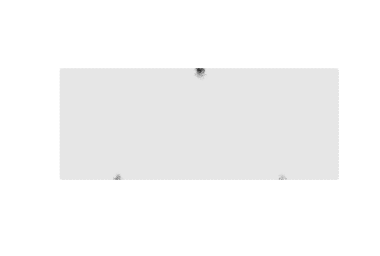

In [26]:
for u, v, data in g.edges_iter(data=True):
    line_x = [ g.node[u]['x'], g.node[v]['x'] ]
    line_y = [ g.node[u]['y'], g.node[v]['y'] ]
    
    c = (data['weight'] / 1500)
    if c > 0.9:
        c = 0.9
    elif c < 0:
        c = 0
    
    plt.plot(line_x, line_y, '-', color=(c, c, c), linewidth=1)


plt.xlim(-50, 50)
plt.axis('equal')
plt.axis('off')
plt.show()

In [27]:
nodes = nx.shortest_path(g, '28.0_-18.0', '0.0_18.0', weight='weight')
x = [28,28,28,28]
y = [-22,-21,-20,-19]
for i in range(0, len(nodes) - 1 ):
    line_x = [ g.node[nodes[i]]['x'], g.node[nodes[i+1]]['x'] ]
    line_y = [ g.node[nodes[i]]['y'], g.node[nodes[i+1]]['y'] ]
    
    x.append(g.node[nodes[i]]['x'])
    y.append(g.node[nodes[i]]['y'])

x.append(g.node[nodes[i+1]]['x'])
y.append(g.node[nodes[i+1]]['y'])
x.append(0)
y.append(19)
x.append(0)
y.append(20)
x.append(0)
y.append(21)
x.append(0)
y.append(22)
x.append(0)
y.append(23)

# interpolate the line
tck,u=interpolate.splprep([x,y],s=10.0)
x_1,y_1= interpolate.splev(np.linspace(0,1,100),tck)

force_path_one = pyx.path.line(x_1[0], y_1[0], x_1[1], y_1[1])
for i in range(2, len(x_1)-1):
    force_path_one.append(pyx.path.lineto(x_1[i], y_1[i]))
    

In [28]:
perimeter_plot = pyx.canvas.canvas()
for i in range(0, len(perimeter_lines)):
    line = perimeter_lines[i]
    perimeter_plot.stroke(line, [pyx.color.rgb.black, pyx.style.linewidth(0.3)])
    
perimeter_plot.stroke(force_path_one, [pyx.color.rgb.red, pyx.style.linewidth(0.3)])

perimeter_plot.writeSVGfile('force_path_one.svg')

![center](force_path_one.svg)

## Creating offset force paths

In [29]:
offset_range = [-2.4, -1.6, -0.8, 0.0, 0.8, 1.6, 2.4]
force_pathways_one = []
for i, offset in enumerate(offset_range):
    if offset == 0:
        force_pathways_one.append(force_path_one)
    else:
        force_pathways_one.append(pyx.deformer.parallel(offset).deform(force_path_one))

## Plotting addition force lines

In [30]:
perimeter_plot = pyx.canvas.canvas()
for i in range(0, len(perimeter_lines)):
    line = perimeter_lines[i]
    perimeter_plot.stroke(line, [pyx.color.rgb.black, pyx.style.linewidth(0.3)])

for i in range(0, len(force_pathways_one)):
    perimeter_plot.stroke(force_pathways_one[i], [pyx.color.rgb.green, pyx.style.linewidth(0.3)])
    
perimeter_plot.stroke(force_path_one, [pyx.color.rgb.red, pyx.style.linewidth(0.3)])

perimeter_plot.writeSVGfile('force_pathways_one.svg')

![center](force_pathways_one.svg)

## Creating polygon from inner perimeter line

In [31]:
inner_perimeter = perimeter_lines[-1]
# Create perimeter polygon
perimeter_positions = []
path_length = inner_perimeter.arclen()
for line_pos in np.arange(0, 1, 0.005):
    line_pos = line_pos * path_length # get the x, y position
    x = inner_perimeter.at(line_pos)[0].t*100
    y = inner_perimeter.at(line_pos)[1].t*100
    perimeter_positions.append( (x,y) )


inner_perimeter_poly = geometry.Polygon(*perimeter_positions)

## Determining intersects within inner perimeter

In [32]:
final_lines = []
# get length of line
for force_path in force_pathways_one:
    final_line = None
    path_length = force_path.arclen()
    min_path_check = path_length.t * 0.2
    max_path_check = path_length.t * 0.8
    #print(path_length)
    start_line = True
    # for each increment along its length
    for line_pos in np.arange(0, 1.005, 0.005):
        # comes out in a weird format (t, u, v w, x) m style pyx's format
        line_pos = line_pos * path_length
        x = force_path.at(line_pos)[0].t*100
        y = force_path.at(line_pos)[1].t*100
    
        if line_pos.t < min_path_check or line_pos.t > max_path_check:
            #print('Testing Enclosed', line_pos)
            point = geometry.Point(x, y) # generate a point
            # Check if point lies within polygon
            if inner_perimeter_poly.encloses(point):
                if start_line:
                    final_line = pyx.path.line(x, y, x, y)
                    start_line = False
                else:
                    final_line.append(pyx.path.lineto(x, y))
        else:
            final_line.append(pyx.path.lineto(x, y))

    print(final_line.arclen().t*100, len(final_line))
    final_lines.append(final_line)



47.14510013387342 170
46.99174563691636 170
47.11731993197509 171
47.24055635945896 172
47.36200087929334 173
47.20583515001929 173
47.04933122185797 173


## Plotting Force Paths Intersecting Perimeter

In [33]:
perimeter_plot = pyx.canvas.canvas()
for i in range(0, len(perimeter_lines)):
    line = perimeter_lines[i]
    perimeter_plot.stroke(line, [pyx.color.rgb.black, pyx.style.linewidth(0.3)])

for i in range(0, len(final_lines)):
    perimeter_plot.stroke(final_lines[i], [pyx.color.rgb.green, pyx.style.linewidth(0.3)])

perimeter_plot.writeSVGfile('force_pathways_intersect.svg')

![center](force_pathways_intersect.svg)

## Mesh Lines

In [34]:
x_mesh_line_range = np.arange(-46.0, 47.1, 8.0)
x_mesh_lines = []
for mesh_line_pos in x_mesh_line_range:
    x_mesh_lines.append(pyx.path.line(mesh_line_pos, -18.5, mesh_line_pos, 18.5))
    
y_mesh_line_range = np.arange(-16.0, 17.1, 8.0)
y_mesh_lines = []
for mesh_line_pos in y_mesh_line_range:
    y_mesh_lines.append(pyx.path.line(-48.5, mesh_line_pos, 48.5, mesh_line_pos))

In [35]:
perimeter_plot = pyx.canvas.canvas()
for i in range(0, len(perimeter_lines)):
    line = perimeter_lines[i]
    perimeter_plot.stroke(line, [pyx.color.rgb.black, pyx.style.linewidth(0.3)])

for i in range(0, len(final_lines)):
    perimeter_plot.stroke(final_lines[i], [pyx.color.rgb.green, pyx.style.linewidth(0.3)])

for i in range(0, len(x_mesh_lines)):
    perimeter_plot.stroke(x_mesh_lines[i], [pyx.color.rgb.blue, pyx.style.linewidth(0.3)])
    
for i in range(0, len(y_mesh_lines)):
    perimeter_plot.stroke(y_mesh_lines[i], [pyx.color.rgb.red, pyx.style.linewidth(0.3)])

perimeter_plot.writeSVGfile('force_pathways_intersect_mesh_overlay.svg')

![center](force_pathways_intersect_mesh_overlay.svg)

In [36]:
def mesh_intersects(mesh_lines, force_path_left, force_path_right):

    # my code
    print('Generating Mesh Intersects')
    # resulting mesh lines that intersect neatly with the force path
    new_mesh_lines = []

    for mesh_line in mesh_lines:
        mesh_intersect_flag = False
        xstart, ystart = mesh_line.atbegin()
        xend, yend = mesh_line.atend()

        # right
        intersect = mesh_line.intersect(force_path_right)
        if len(intersect[0]) > 0: # if not an empty list,
            a1 = intersect[0][0]
            x1, y1 = mesh_line.at(a1)
            print(x1.t*100, y1.t*100)
            new_mesh_lines.append(pyx.path.line(xstart.t*100, ystart.t*100, x1.t*100, y1.t*100))
            mesh_intersect_flag = True
        else:
            print('No Intersection Detected')

        # left
        intersect = mesh_line.intersect(force_path_left)
        if len(intersect[0]) > 0: # if not an empty list,
            a1 = intersect[0][0]
            x1, y1 = mesh_line.at(a1)
            print(x1.t*100, y1.t*100)
            new_mesh_lines.append(pyx.path.line(xend.t*100, yend.t*100, x1.t*100, y1.t*100))
            mesh_intersect_flag = True
        else:
            print('No Intersection Detected')

        if not mesh_intersect_flag: # if the line has not intersected the force pathway
            new_mesh_lines.append(mesh_line)

    return(new_mesh_lines)

In [37]:
x_mesh_lines_intersect = mesh_intersects(x_mesh_lines, final_lines[0], final_lines[-1])

y_mesh_lines_intersect = mesh_intersects(y_mesh_lines, final_lines[0], final_lines[-1])

Generating Mesh Intersects
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
2.0 8.601604469338552
No Intersection Detected
10.0 0.4911709112326846
10.0 7.136912928418421
18.0 -7.223416984112656
18.0 -0.5064632201829354
26.0 -16.28774161190597
26.0 -8.451160192161849
No Intersection Detected
No Intersection Detected
No Intersection Detected
No Intersection Detected
Generating Mesh Intersects
25.869045337605762 -16.0
30.93876554923763 -16.0
18.782939088016267 -8.0
25.55724438238952 -8.0
10.519688371791645 0.0
17.476016169843124 0.0
2.5219186429997755 8.0
9.12714935933556 8.0
-2.268830867635018 16.0
2.780261928313583 16.0


In [38]:
perimeter_plot = pyx.canvas.canvas()
for i in range(0, len(perimeter_lines)):
    line = perimeter_lines[i]
    perimeter_plot.stroke(line, [pyx.color.rgb.black, pyx.style.linewidth(0.3)])

for i in range(0, len(final_lines)):
    perimeter_plot.stroke(final_lines[i], [pyx.color.rgb.green, pyx.style.linewidth(0.3)])

for i in range(0, len(x_mesh_lines_intersect)):
    perimeter_plot.stroke(x_mesh_lines_intersect[i], [pyx.color.rgb.blue, pyx.style.linewidth(0.3)])
    
for i in range(0, len(y_mesh_lines_intersect)):
    perimeter_plot.stroke(y_mesh_lines_intersect[i], [pyx.color.rgb.red, pyx.style.linewidth(0.3)])

perimeter_plot.writeSVGfile('force_pathways_intersect_mesh_intersect.svg')

![center](force_pathways_intersect_mesh_intersect.svg)

In [1]:
# Setting the css styling of the notebook
from IPython.core.display import HTML

def load_css():
    style = open("../extras/custom.css", "r").read()
    return HTML("<style>"+style+"</style>")

load_css()